In [15]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import wilcoxon
import math

In [16]:
result_path = '../results/nsyb-G7f-rAch1h'
sub_path_1 = 'voxel-integration-region-SRD-long-formal'
sub_path_2 = 'mean_region_pca_DEEPCAD_formal'
filename = 'accuracy' # accuracy / accuracy_svm / AUC_weighted / f1_weighted
if_save = True
fly_selected = [0,1,2,3,4,5,6,7,8,9]
num_fly = len(fly_selected)
dim_thresh = 25
expr_thresh = 0.995
thresh = np.arange(0,1,0.005)

figure_save_path = '../../figures-revision-1'
folder = os.path.exists(figure_save_path)
if not folder:
    os.makedirs(figure_save_path)

In [17]:
# read voxel
file_folders = os.listdir(result_path)
data_1 = []
num_dim = []
for i in range(num_fly):
    # load data
    the_path = result_path + '/' + file_folders[fly_selected[i]] + '/' + sub_path_1 + '/' + 'list_list_' + filename + '.npy'
    folder = os.path.exists(the_path)
    if not folder:
        continue
    a = np.load(the_path)
    a = np.squeeze(a)
    if np.size(a,1) == 5:
        a = np.squeeze(a[:,2,:,:,:])
    data_1.append(a)
    # load num_dim
    the_path = result_path + '/' + file_folders[fly_selected[i]] + '/' + sub_path_1 + '/' + 'list_list_num_dim.npy'
    folder = os.path.exists(the_path)
    if not folder:
        continue
    a = np.load(the_path)
    a = np.squeeze(a)
    if np.size(a,1) == 5:
        a = np.squeeze(a[:,2,:,:])
    num_dim.append(a)
data_1 = np.array(data_1)
print(np.shape(data_1))
num_dim = np.array(num_dim)
print(np.shape(num_dim))

(10, 3, 50, 5, 2)
(10, 3, 50, 2)


In [18]:
# read each region
data_2 = []
for i in range(num_fly):
    the_path = result_path + '/' + file_folders[fly_selected[i]] + '/' + sub_path_2 + '/' + 'list_list_' + filename + '_br.npy'
    folder = os.path.exists(the_path)
    if not folder:
        continue
    a = np.load(the_path)
    a = np.squeeze(a)
    data_2.append(a)
data_2 = np.array(data_2)
np.shape(data_2)

(10, 3, 200, 5, 2)

In [19]:
# voxel threshold
max_data_1 = np.zeros((num_fly,np.size(data_1,1),np.size(data_1,4)))
for i in range(num_fly):
    for j in range(np.size(data_1,1)):
        for k in range(np.size(data_1,4)):
            flag = 0
            for m in range(np.size(data_1,2)):
                if num_dim[i,j,m,k]>=dim_thresh:
                    flag = m
                    break
            a = data_1[i,j,int(flag),:,k]
            max_data_1[i,j,k] = np.mean(a)
np.shape(max_data_1)

(10, 3, 2)

In [20]:
# each region threshold
max_data_2 = np.mean(data_2,3)
max_data_2 = np.squeeze(max_data_2[:,:,thresh==expr_thresh,:])
np.shape(max_data_2)

(10, 3, 2)

(10, 1)
(10, 1)
(10, 2)
0.0009765625


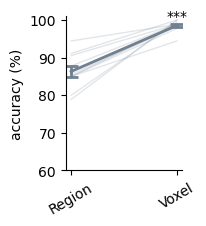

(10, 1)
(10, 1)
(10, 2)
0.0009765625


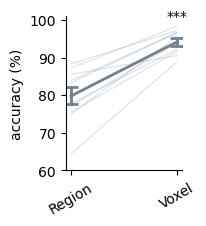

(10, 1)
(10, 1)
(10, 2)
0.0009765625


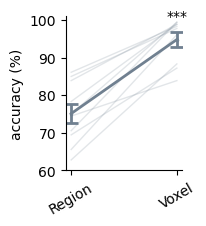

In [21]:
# only compare 1 channel
ymin = [60,60,60]
for i in range(np.size(max_data_2,1)):
    a = max_data_1[:,i,0]####
    b = max_data_2[:,i,0]####
    a = a[:,np.newaxis]
    print(np.shape(a))
    b = b[:,np.newaxis]
    print(np.shape(b))
    data_save = np.concatenate((b,a),axis = 1)
    print(np.shape(data_save))
    flag = np.size(data_save,1)
    data_save = data_save*100
    # plot
    num_fly = np.size(data_save,0)
    color_list = plt.cm.tab10(np.linspace(0,1,num_fly))
    plt.figure(figsize = (1.5,2))
    ax = plt.axes()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    for k in range(num_fly):
        plt.plot(data_save[k,:],color='slategray', linewidth=1,alpha = 0.2)
    the_mean = np.mean(data_save,0)
    the_std = np.std(data_save,0,ddof = 1)/math.sqrt(num_fly) 
    plt.errorbar(range(np.size(data_save,1)),the_mean,yerr=the_std,ecolor='slategray',elinewidth=2,marker='.',mfc='slategray',\
	mec='slategray',mew=2,ms=1,alpha=1,capsize=5,capthick=3,color='slategray', linewidth=2)
    plt.ylim((ymin[i],101))
    plt.xticks(np.linspace(0,flag-1,flag),['Region','Voxel'],rotation = 30)
    plt.ylabel(filename + ' (%)')
    # wilcoxon test
    for j in range(1,flag):
        res = wilcoxon(data_save[:,0],data_save[:,j],alternative = 'less')
        p = res.pvalue
        print(p)
        if p<0.05 and p>=0.01:
            plt.text(j,101,'*',verticalalignment = 'center', horizontalalignment = 'center')
        elif p<0.01 and p>0.001:
            plt.text(j,101,'**',verticalalignment = 'center', horizontalalignment = 'center')
        elif p<0.001 and p>=0.0001:
            plt.text(j,101,'***',verticalalignment = 'center', horizontalalignment = 'center') 
        elif p<0.0001:
            plt.text(j,101,'****',verticalalignment = 'center', horizontalalignment = 'center') 
    if if_save:
        mpl.rcParams['pdf.fonttype'] = 42
        mpl.rcParams['ps.fonttype'] = 42
        plt.savefig(figure_save_path + '/' + 's5efg1_'+ filename +'1_voxel_over_region_c'+str(i)+'.pdf',bbox_inches = 'tight')
        plt.savefig(figure_save_path + '/' + 's5efg1_'+ filename +'1_voxel_over_region_c'+str(i)+'.png',bbox_inches = 'tight')
    plt.show()